<html>
   <body>
    <p style="font-size:30px; color:orange; font-family:'Courier New';text-align:center"> 
        Pilot 3 Validation : Feature Creation</p>
  </body>
</html>

Python notebook to create episodes, Average daily dose, maintenance dose, first and last monthly dose, demographics, current medication and time between enrollment & shipping

In [1]:
#import required libs
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
from datetime import timedelta

import os
import regex as re

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)
sns.set()

## Defining the Outcome

### Grace Period 

To determine grace period, difference between current and previous shipment (cumulative sum in days) is plotted.

Based on the team inputs and observed differences between claims for the graph shown below, 90 days was decided as the adequate grace period

In [2]:
#converting dates to required format
shipping = pd.read_csv('Data/shipping.csv')

shipping['Order Date'] = shipping['Order Date'].apply(
    lambda x: datetime.strptime(x, '%m/%d/%Y'))

shipping['Order Date Old'] = shipping['Order Date']

## Order Date refers to actual shipment date - Order date + shipping time = Shipment date
shipping['Order Date'] = pd.to_datetime(
    shipping['Order Date']) + pd.to_timedelta(
        pd.np.ceil(shipping['difference']), unit="D")

In [3]:
#caclulating and plotting diff in days between previous and current shipment - cumulative sum
shipping = shipping.sort_values(by=['Patient ID', 'Order Date']).reset_index(
    drop=True)

shipping['Previous Date'] = (shipping.sort_values(
    by=['Patient ID', 'Order Date']).groupby(['Patient ID'
                                              ])['Order Date'].shift(1))

shipping['diff'] = shipping['Order Date'] - shipping['Previous Date']

shipping['diff_int'] = pd.to_numeric(shipping['diff'].dt.days,
                                     downcast='integer')

temp = shipping[shipping['diff_int'] > 0]



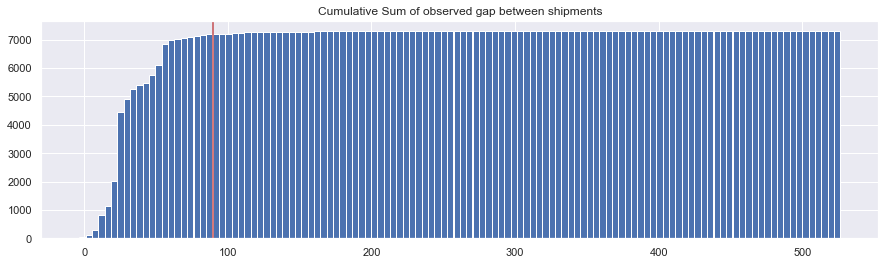

In [4]:
sns.set()
plt.figure(figsize=(15, 4))

res = stats.cumfreq(temp['diff_int'], numbins=120)
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                                 res.cumcount.size)
plt.bar(x, res.cumcount, width=res.binsize)
plt.axvline(x=90, ymin=0, ymax=1, color = 'r')
plt.title('Cumulative Sum of observed gap between shipments')
plt.show()

### Episode Creation (assuming grace = 90)

A claim is flagged as the starting of a new episode if : 
1. the previous claim for the patient is >90 days before the given claim OR
2. the given claim is the first claim for the patient 

The episode length is calculated as (date of last claim - date of first claim + 28 days)

In [5]:
#new ep flag = 1 for 1st claim and each claim >90 days after the previous
shipping['new_ep_flag'] = 0


def new_ep_flag(row):
    """ 
    diff_int is created during grace analysis
    
    It is defined as difference in days from current claim and previous claim
    
    """
    if row['diff_int'] >= 90:
        row['new_ep_flag'] = 1
    if pd.isnull(row['diff_int']):
        row['new_ep_flag'] = 1

    return row


shipping = shipping.apply(new_ep_flag, axis=1)

shipping['ep_number'] = shipping.groupby(['Patient ID'
                                          ])['new_ep_flag'].cumsum()

In [6]:
#calculate episode length as difference b/w min and max of order date
episode_info = shipping.groupby(['Patient ID', 'ep_number'
                                 ]).agg(['min',
                                         'max'])['Order Date'].reset_index()

episode_info['length'] = episode_info['max'] - episode_info['min']

episode_info['length_int'] = pd.to_numeric(episode_info['length'].dt.days,
                                           downcast='integer')

#imputing 28 days to all episode lengths - DOS for last clm
episode_info['length_int'] = episode_info['length_int'] + 28

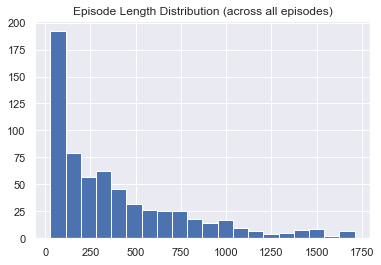

In [7]:
#Episode Length Distribution
plt.hist(episode_info['length_int'], bins=20)
plt.title('Episode Length Distribution (across all episodes)')
plt.show()

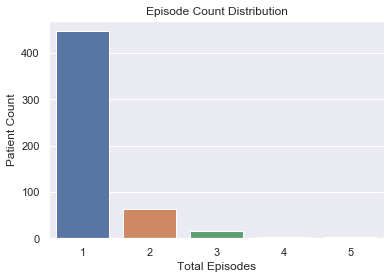

In [8]:
#Episode Count Distribution
temp = pd.DataFrame(episode_info.groupby(['Patient ID']).agg('max')['ep_number'].value_counts()).reset_index()
temp.columns = ['Total Episodes', 'Patient Count']

sns.barplot(y = 'Patient Count', x='Total Episodes', data = temp).set_title('Episode Count Distribution');

In [9]:
#filtering for first episode of each patient
first_ep_info = episode_info[episode_info['ep_number'] == 1]

first_ep_info = pd.merge(first_ep_info,
                         episode_info.groupby(['Patient ID'
                                               ])['ep_number'].agg('max'),
                         how='left',
                         on='Patient ID')

first_ep_info = first_ep_info.drop(['ep_number_x'], axis=1)

first_ep_info = first_ep_info.rename(
    columns={'ep_number_y': 'total_episode_count'})

first_ep_info.columns = [
    'Patient ID', 'Episode Start Date', 'Episode End Date',
    'Episode Length wo Impute', 'Episode Length', 'Total Episode Count'
]

first_ep_info.head(2)

Patient ID Episode Start Date Episode End Date Episode Length wo Impute  \
0  1-1001248391         2015-08-30       2016-02-06                 160 days   
1  1-1001265212         2015-08-30       2018-02-23                 908 days   

   Episode Length  Total Episode Count  
0             188                    1  
1             936                    1

In [10]:
#patients with first episode of single shipment
print('Patients with Episode Length = 28 (single shipment patients) : ',
      len(first_ep_info[first_ep_info['Episode Length'] == 28]))

Patients with Episode Length = 28 (single shipment patients) :  64


### Discontinuation

A patient with multiple episodes is marked as discontinued irrespective of current DC Status. For patients with single episode, the DC Status is used to determine discontinuation

In [11]:
dashboard = pd.read_csv('Data/discontinuation.csv')

In [12]:
#set discontinuation status
first_ep_info = pd.merge(dashboard,
                         first_ep_info,
                         on='Patient ID',
                         how='right')

first_ep_info.loc[first_ep_info['Total Episode Count'] > 1,
                  'DC Status'] = 'Discontinued'

""" DC Status 0 indicates that patient is active """
first_ep_info.loc[first_ep_info['DC Status'] == '0', 'DC Status'] = 'No'
#first_ep_info = first_ep_info.dropna(subset=['Total Episode Count'])

In [13]:
#Discontinuation Status distribution
print('Discontinuation Status for first episode')
pd.DataFrame(first_ep_info['DC Status'].value_counts())

Discontinuation Status for first episode


DC Status
Yes                 254
No                  192
Discontinued         84

## Average Daily Dose Calculation

For average dose calculation for a given claim : 
1. Strength is extracted from the 'Product Name' as an integer
2. Days of supply is calculated as the difference in days between the current claim and next claim
    * For cases when days of supply cannot be calculated, such as last claim of an episode, value is imputed as 28 days
3. Multiple shipments on the same day are rolled up together 

The average claim dose per day is then calculated as : (Quantity * Strength) / Days of Supply

In [14]:
#onverting dates to required format
dosage = pd.read_csv('Data/shipping.csv')

dosage['Order Date'] = dosage['Order Date'].apply(
    lambda x: datetime.strptime(x, '%m/%d/%Y'))

dosage['Order Date Old'] = dosage['Order Date']

#Order Date refers to the "Date Actual Shipment Type Finalized" Column everywhere
dosage['Order Date'] = pd.to_datetime(dosage['Order Date']) + pd.to_timedelta(
    pd.np.ceil(dosage['difference']), unit="D")

In [15]:
#filter for first episode
dosage = pd.merge(
    dosage,
    first_ep_info[['Patient ID', 'Episode Start Date', 'Episode End Date']],
    how="right",
    on="Patient ID")

dosage = dosage[(dosage['Order Date'] <= dosage['Episode End Date']) & (dosage['Order Date'] >= dosage['Episode Start Date'])]

In [16]:
#extract strength
dosage['Strength'] = dosage['Product Name'].apply(
    lambda x: int(re.findall(r"(\d+)MCG", x)[0]))

dosage['dose'] = dosage['Strength'] * dosage['Qty']

#dosage.head(2)

In [17]:
#calculate days of supply

## Updated shipment id by removing last 2 characters
#dosage['Total Shipment'] = dosage['Shipment ID'].apply(lambda x: x[:-2])

dosage = dosage.sort_values(by=['Patient ID', 'Order Date']).reset_index(
    drop=True)

dosage['Next Date'] = (dosage.sort_values(
    by=['Patient ID', 'Order Date']).groupby(['Patient ID'
                                              ])['Order Date'].shift(-1))

dosage['diff'] = dosage['Next Date'] - dosage['Order Date']

dosage['days_of_supply'] = pd.to_numeric(dosage['diff'].dt.days,
                                         downcast='integer')

dosage['days_of_supply'] = dosage['days_of_supply'].fillna(28)

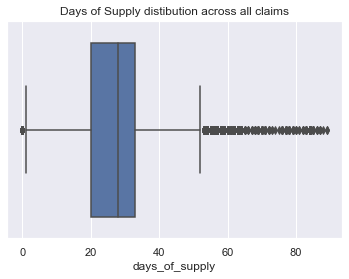

In [18]:
#Days of Supply Distribution
sns.boxplot(data=dosage, x="days_of_supply")
plt.title('Days of Supply distibution across all claims')
plt.show()

In [19]:
#calculate total dose by combining patients on Shipment and Order Date level
dosage['total_dose'] = dosage['Qty'] * dosage['Strength']

avg_daily_dose = dosage.groupby(
    ['Patient ID',
     'Order Date'])['days_of_supply', 'total_dose'].sum().reset_index()

avg_daily_dose['avg_dose'] = round(
    avg_daily_dose['total_dose'] / avg_daily_dose['days_of_supply'], 0)

avg_daily_dose = avg_daily_dose.replace([np.inf, -np.inf], np.nan)

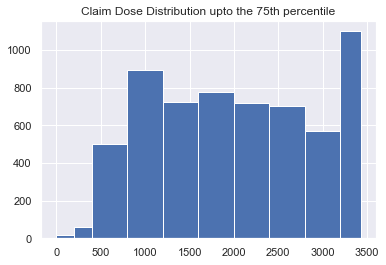

In [21]:
#dose distribution for acceptable values (75th percentile)
sns.set()

plt.hist(avg_daily_dose['avg_dose'],
             bins=[0, 200, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3429])
plt.title("Claim Dose Distribution upto the 75th percentile")
plt.show()

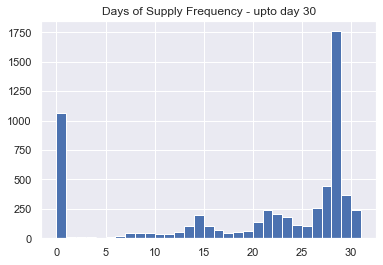

In [22]:
#days of supply for first 30 days
sns.set()

plt.hist(dosage['days_of_supply'],
             bins=[
                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
             ])

plt.title('Days of Supply Frequency - upto day 30')
plt.show()

#### Rolling up to 30 day intervals

The average monthly dose is calculated as the weighted average of all claims that were active during the given month. 
The dose value is capped at a maximum of 3200 mcg. 

The first and last monthly dose are then taken as the first monthly and last monthly average dose for the given episode respectively

In [23]:
# get day wise distribution for all patients
avg_daily_dose['Date End'] = pd.to_datetime(
    avg_daily_dose['Order Date']) + pd.to_timedelta(
        pd.np.ceil(avg_daily_dose['days_of_supply'] - 1), unit="D")

ptids = list(avg_daily_dose['Patient ID'].drop_duplicates())

day_wise = pd.DataFrame(columns=['Patient ID', 'Order Date', 'avg_dose'])

for ptid in ptids:
    temp = avg_daily_dose[avg_daily_dose['Patient ID'] == ptid]
    temp.set_index('Order Date', inplace=True)

    a = temp.tail(1)
    a.set_index('Date End', inplace=True)
    temp = temp.append(a)

    temp.index = pd.to_datetime(temp.index)
    x = temp.resample('1D').mean().fillna(method='ffill').reset_index()[[
        'index', 'avg_dose'
    ]]
    
    x['Patient ID'] = ptid

    day_wise = day_wise.append(x)

day_wise = day_wise.drop(columns=['Order Date'])
day_wise.columns = ['Patient ID', 'avg_dose', 'Order Date']
day_wise = day_wise.reset_index(drop=False)
day_wise['month'] = day_wise['index'] // 30

day_wise.head(10)

index    Patient ID  avg_dose Order Date  month
0      0  1-1001248391     490.0 2015-08-30      0
1      1  1-1001248391     490.0 2015-08-31      0
2      2  1-1001248391     490.0 2015-09-01      0
3      3  1-1001248391     490.0 2015-09-02      0
4      4  1-1001248391     490.0 2015-09-03      0
5      5  1-1001248391     490.0 2015-09-04      0
6      6  1-1001248391     490.0 2015-09-05      0
7      7  1-1001248391     490.0 2015-09-06      0
8      8  1-1001248391     490.0 2015-09-07      0
9      9  1-1001248391     490.0 2015-09-08      0

In [24]:
# roll up day wise distribution to get monthly dose
monthly_avg_dose = day_wise.groupby(['Patient ID', 'month'
                                     ]).agg('mean')['avg_dose'].reset_index()

In [25]:
#cap to 3200
monthly_avg_dose.loc[monthly_avg_dose['avg_dose'] > 3200, 'avg_dose'] = 3200

In [26]:
import seaborn as sns
print(sns.__version__)

0.10.0


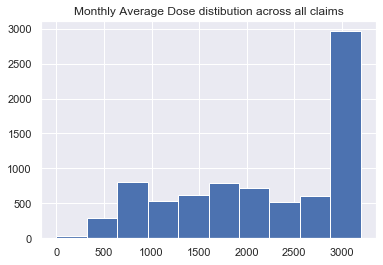

In [27]:
#Monthly average distribution
plt.hist(monthly_avg_dose['avg_dose'])
plt.title('Monthly Average Dose distibution across all claims')
plt.show()


#### First and Last Monthly Dose

In [28]:
#get first and last monthly dose for each episode
last_daily_dose = monthly_avg_dose.groupby(
    ['Patient ID']).apply(lambda t: t.iloc[-1]).reset_index(drop=True)

first_daily_dose = monthly_avg_dose.groupby(
    ['Patient ID']).apply(lambda t: t.iloc[0]).reset_index(drop=True)

final_dose_table = pd.merge(first_daily_dose,
                            last_daily_dose,
                            how="left",
                            on="Patient ID")

final_dose_table = final_dose_table.drop(['month_x'], axis=1)

final_dose_table.columns = [
    'Patient ID', 'First Monthly Average Dose', 'Last Month Indicator',
    'Last Monthly Average Dose'
]

final_dose_table['Last Monthly Average Dose'] = round(
    final_dose_table['Last Monthly Average Dose'], 0)

final_dose_table['First Monthly Average Dose'] = round(
    final_dose_table['First Monthly Average Dose'], 0)

In [29]:
first_ep_info = pd.merge(first_ep_info,
                         final_dose_table,
                         how="left",
                         on="Patient ID")

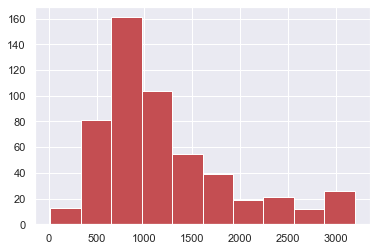

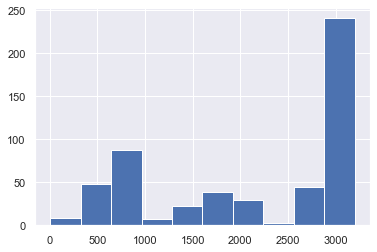

In [30]:
#  First vs Last monthly dose plot 
plt.hist(first_ep_info['First Monthly Average Dose'],
            color='r',
            #shade=True,
            Label='First Monthly Average Dose');
plt.show()
plt.hist(first_ep_info['Last Monthly Average Dose'],
            color='b',
            #shade=True,
            Label='Last Monthly Average Dose')

#plt.title('First vs Last Monthly Average Dose')
plt.show()

#### Maintenence Dose

A patient is assumed to be titrating as long as the percent change between the current and next dose is more than 15 percent.

1. The first dose of every episode is assumed as a titration dose. 

2. The first monthly dose where percent change is lesser than or equal to 1 percent is taken as the first maintenence dose

3. The first month during which the patient records a maintenence dose is taken as the time to first maintenence

4. Average of all maintenence dose during which the patient is not flagged as titrating is taken as the average maintenence dose

In [31]:
#create a titration flag for all claims where percent change is greater than threshold and the first episode claim 

threshold = 15

titration = monthly_avg_dose.copy(deep=True)

titration['prev_dose'] = titration.sort_values(
    by=['Patient ID', 'month']).groupby(['Patient ID'])['avg_dose'].shift(1)

titration['delta'] = titration['avg_dose'] - titration['prev_dose']

titration['percent_change'] = round(
    titration['delta'] * 100 / titration['prev_dose'], 2)


titration.loc[abs(titration['percent_change']) > threshold, 'titration_flag'] = 1
titration.loc[titration['month'] == 0, 'titration_flag'] = 1
titration['titration_flag'] = titration['titration_flag'].fillna(0)

titration.head(2)

Patient ID  month  avg_dose  prev_dose  delta  percent_change  \
0  1-1001248391      0     490.0        NaN    NaN             NaN   
1  1-1001248391      1    1305.5      490.0  815.5          166.43   

   titration_flag  
0             1.0  
1             1.0

In [32]:
#calculation of average maintenence dose
maintenence_dose = titration.groupby(['Patient ID', 'titration_flag'
                                      ]).agg('mean')['avg_dose'].reset_index()

maintenence_dose = maintenence_dose[maintenence_dose['titration_flag'] == 0]

In [33]:
#calculation of first maintenence dose
first_maintenence = titration[titration['titration_flag'] == 0].sort_values(
    by=['Patient ID', 'month']).groupby(['Patient ID']).first().reset_index()[[
        'Patient ID', 'month', 'avg_dose'
    ]]

In [34]:
#merge into one table
first_maintenence = pd.merge(first_maintenence,
                             maintenence_dose[['Patient ID', 'avg_dose']],
                             how='left',
                             on='Patient ID')

first_maintenence.columns = [
    'Patient ID', 'Time To First Maintenence', 'First Maintenence Dose',
    'Average Maintenence Dose'
]

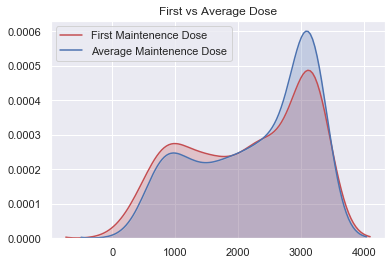

In [35]:
#  First vs Last monthly dose plot 
sns.kdeplot(first_maintenence['First Maintenence Dose'],
            color='r',
            shade=True,
            Label='First Maintenence Dose')

sns.kdeplot(first_maintenence['Average Maintenence Dose'],
            color='b',
            shade=True,
            Label='Average Maintenence Dose')

plt.title('First vs Average Dose')
plt.show()

In [36]:
first_ep_info = pd.merge(first_ep_info,
                         first_maintenence,
                         how="left",
                         on="Patient ID")

first_ep_info.head(2)

Patient ID DC Status Episode Start Date Episode End Date  \
0  1-1001248391       Yes         2015-08-30       2016-02-06   
1  1-1001265212        No         2015-08-30       2018-02-23   

  Episode Length wo Impute  Episode Length  Total Episode Count  \
0                 160 days             188                    1   
1                 908 days             936                    1   

   First Monthly Average Dose  Last Month Indicator  \
0                       490.0                     6   
1                      1028.0                    31   

   Last Monthly Average Dose  Time To First Maintenence  \
0                     1714.0                        2.0   
1                     3200.0                        3.0   

   First Maintenence Dose  Average Maintenence Dose  
0             1171.000000               1477.583333  
1             2571.333333               3111.530864

## Demographics

A patient is assumed on Private Insurance when they have a copay value present in the reimbursement data

In [37]:
demogs = pd.read_csv('Data/demographics.csv')
reimburse = pd.read_csv('Data/reimburse.csv')

In [38]:
#insurance
reimburse = reimburse[reimburse['Copay %'] > 0].dropna(subset=['Copay %'])

insurance = pd.DataFrame(
    reimburse['Patient ID'].drop_duplicates().reset_index(drop=True))
insurance['Private Insurance'] = 1

demogs = pd.merge(demogs,
                  insurance,
                  left_on="SHN Patient ID",
                  right_on="Patient ID",
                  how="left").fillna(0).drop(['Patient ID'], axis=1)

demogs.drop_duplicates(subset=['SHN Patient ID'], keep='first')

demogs.rename(columns={"SHN Patient ID": "Patient ID"}, inplace=True)

demogs.head(2)

Patient ID  Patient Province  Age Gender  Private Insurance
0  1-10627915139               0.0   65      F                0.0
1  1-12562749685               0.0    1      F                0.0

Patient Distribution by Age : 


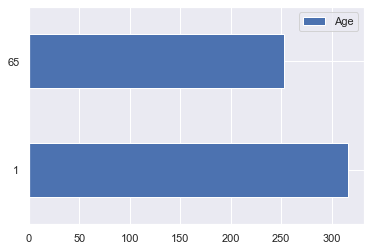

In [39]:
print('Patient Distribution by Age : ')
sns.set()
pd.DataFrame(demogs['Age'].value_counts()).plot(kind = 'barh') ; 

Patient Distribution by Gender : 


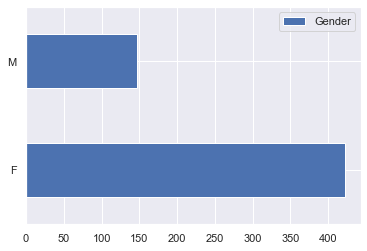

In [40]:
print('Patient Distribution by Gender : ')
pd.DataFrame(demogs['Gender'].value_counts()).plot(kind = 'barh') ;

In [41]:
print('Patients on private Insurance : ', demogs.sum()['Private Insurance'])

Patients on private Insurance :  83.0


In [42]:
first_ep_info = pd.merge(first_ep_info, demogs, how='left', on='Patient ID')

## Current Medications

The patient is assumed to be taking a given medication when atleast one record of the patient on the given medication is present in the drog mapping table

In [43]:
mapping = pd.read_csv('Data/drug mapping.csv')
meds = pd.read_csv('Data/current_meds.csv')

In [44]:
#create medication table from mapping
temp = pd.merge(meds[['Patient ID', 'OTHR_DESC']].drop_duplicates(),
                mapping,
                left_on='OTHR_DESC',
                right_on='Flag',
                how="right")

temp = temp.groupby(['Patient ID', 'Class'])['Flag'].agg('count').reset_index()

medications = temp.pivot_table(index=['Patient ID'],
                               columns='Class',
                               values='Flag').reset_index().fillna('0')

medications = medications.drop_duplicates(subset=['Patient ID'], keep='first')

In [45]:
medications.describe()

Class     Patient ID ARBs  Diuretics    ERA   PDE5 ambrisentan bosentan  \
count            452  452      452.0  452.0  452.0         452      452   
unique           452    2        3.0    3.0    3.0           2        3   
top     1-5066146446    0        1.0    1.0    1.0           0        0   
freq               1  431      223.0  244.0  266.0         445      360   

Class  macitentan oxygen sildenafil tadalafil  
count         452    452        452       452  
unique          3      2          2         2  
top             0      0          0         0  
freq          344    405        406       422

In [46]:
first_ep_info = pd.merge(first_ep_info,
                         medications,
                         how='left',
                         on='Patient ID')

first_ep_info = first_ep_info.fillna('0')

first_ep_info.head(2)

Patient ID DC Status Episode Start Date Episode End Date  \
0  1-1001248391       Yes         2015-08-30       2016-02-06   
1  1-1001265212        No         2015-08-30       2018-02-23   

  Episode Length wo Impute  Episode Length  Total Episode Count  \
0                 160 days             188                    1   
1                 908 days             936                    1   

   First Monthly Average Dose  Last Month Indicator  \
0                       490.0                     6   
1                      1028.0                    31   

   Last Monthly Average Dose Time To First Maintenence First Maintenence Dose  \
0                     1714.0                         2                   1171   
1                     3200.0                         3                2571.33   

  Average Maintenence Dose  Patient Province  Age Gender  Private Insurance  \
0                  1477.58               0.0    1      M                0.0   
1                  3111.53               0.0    1      F                0.0   

  ARBs Diuretics ERA PDE5 ambrisentan bosentan macitentan oxygen sildenafil  \
0    0         0   1    1           0        1          0      0          0   
1    0         0   1    1           0        0          0      0          0   

  tadalafil  
0         0  
1         0

## Time bw Enrollment & Shipping

The time between enrollment and first shipment is calculated as the difference (in days) between the enrollment and shipment dates. 

In [47]:
#getting enrollment and shipping days in date format 
enrollment = pd.read_csv('Data/dashboard_enrollment.csv')

enrollment['Enrollment Date'] = enrollment['Enrollment Date'].apply(
    lambda x: datetime.strptime(x, '%m/%d/%Y'))

shipping = pd.read_csv('Data/shipping.csv')

shipping['Order Date'] = shipping['Order Date'].apply(
    lambda x: datetime.strptime(x, '%m/%d/%Y'))

shipping['Order Date Old'] = shipping['Order Date']

shipping['Order Date'] = pd.to_datetime(
    shipping['Order Date']) + pd.to_timedelta(
        pd.np.ceil(shipping['difference']), unit="D")

In [48]:
#time between enrollment and first shipping calculation 
temp = pd.merge(enrollment[['SHN Patient ID', 'Enrollment Date']],
                shipping.groupby(['Patient ID'
                                  ])['Order Date'].agg('min').reset_index(),
                how='left',
                left_on='SHN Patient ID',
                right_on='Patient ID')

temp['diff'] = temp['Order Date'] - temp['Enrollment Date']

temp['diff'] = pd.to_numeric(temp['diff'].dt.days, downcast='integer')

temp = temp[temp['diff'] >= 0]

time_bw_enroll_ship = temp.groupby(['Patient ID'])['diff'].min().reset_index()

time_bw_enroll_ship.columns = ['Patient ID', 'Erollment To Shipping Days']

time_bw_enroll_ship.head(2)

Patient ID  Erollment To Shipping Days
0  1-1001248391                        14.0
1  1-1001265212                         2.0

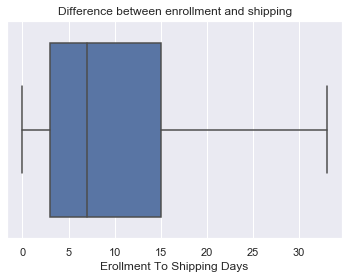

In [52]:
#Distribution
sns.boxplot(data=time_bw_enroll_ship, x="Erollment To Shipping Days", showfliers = False)
plt.title('Difference between enrollment and shipping')
plt.show()


In [50]:
first_ep_info = pd.merge(first_ep_info,
                         time_bw_enroll_ship,
                         how="left",
                         on="Patient ID")

In [53]:
#first_ep_info.to_csv('Intermediate Outputs/202105 Feature Creation Output.csv')
#monthly_avg_dose.to_csv('Intermediate Outputs/202105 Monthly Average Dose.csv')